#  Model Finalization Steps:
1. Select only 25% the original number of peptides
2. Grid Search classifier hyper-parameters

In [1]:
### Combine parent directory to path for access to Classification_Utils and FullPeptideQuant.txt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import numpy as np
from os import listdir
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
import time

## Load Dataframe

In [3]:
df = pd.read_csv('..\FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(55676, 253)


## Map each column to a corresponding label

In [4]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [5]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [6]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW006_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW007_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW008_8Apr16_Arwen_16-01-03,...,Temporal_Lobe_Alz_FX1P159_Guan_1_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_2_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_3_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_1_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_2_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_3_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX2P57_IMAC_153_9May11_Hawk_11-04-02p,Temporal_Lobe_Alz_FX2P57_IMAC_161_20Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_187_26Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_212_11May11_Hawk_11-04-02p
Peptide,,,,,,,,,,,,,,,,,,,,,
-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,30.458361,29.004130,31.023004,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,32.564995,30.319263,32.368436,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,29.779972,29.747784,30.255299,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,30.845879,30.983525,27.526416,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.EVQLVETGGGLIQPGGSLR.L,24.546220,3.022208,3.022208,3.022208,26.732727,3.022208,28.163126,23.836245,3.022208,28.436388,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


## Make train-test split

In [7]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, test_size=0.30, random_state=0, stratify=labels)

## Tune parameters of best models with Grid Search

In [8]:
GRID_SEARCH_FOLDS = 8
N_JOBS = 1

### Gradient Boosting grid search

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', GradientBoostingClassifier(random_state=0))])
 
MAX_DEPTH = range(5,16,3)
N_ESTIMATORS = [25, 50, 100, 200]
MIN_SAMPLES_SPLIT = [2, 3, 4, 5, 10]
    
gbc_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_depth': MAX_DEPTH 
}

gbc_grid = GridSearchCV(gbc_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=gbc_param_grid)

gbc_grid.fit(train_df, train_labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

Best Gradient Boosting parameters:
 {'classify__max_depth': 8, 'classify__min_samples_split': 10, 'classify__n_estimators': 25}

Best Cross-Validation score:
 0.9774011299435028


In [11]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'gbc_grid_25Percentile.sav'
joblib.dump(gbc_grid, open(model_path, 'wb'))

###  Logistic Regression grid search

In [26]:
from sklearn.linear_model import LogisticRegression

SOLVERS = ['liblinear', 'sag', 'saga']
C_OPTIONS = [.01, .1, 1, 10, 100, 1000]
    
lr_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', LogisticRegression(random_state=0))])


lr_param_grid = {
    'classify__solver': SOLVERS,
    'classify__C': C_OPTIONS
}

lr_grid = GridSearchCV(lr_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=lr_param_grid)
                       
lr_grid.fit(train_df, train_labels)

print('Best Logistic Regression parameters:\n', lr_grid.best_params_)
print('\nBest Cross-Validation score:\n', lr_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best Logistic Regression parameters:
 {'classify__C': 0.01, 'classify__solver': 'liblinear'}

Best Cross-Validation score:
 0.9887005649717514


In [27]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'lr_grid_25Percentile.sav'
joblib.dump(lr_grid, open(model_path, 'wb'))

### Random Forest grid search

In [14]:
from sklearn.ensemble import RandomForestClassifier

MAX_FEATURES = ['auto', 'sqrt', 'log2']

rf_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', RandomForestClassifier(random_state=0))])

    
rf_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_features': MAX_FEATURES
}

rf_grid = GridSearchCV(rf_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=rf_param_grid)

rf_grid.fit(train_df, train_labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

Best Random Forest parameters:
 {'classify__max_features': 'auto', 'classify__min_samples_split': 2, 'classify__n_estimators': 25}

Best Cross-Validation score:
 0.9943502824858758


In [15]:
model_path = finalized_model_folder + 'rf_grid_25Percentile.sav'
joblib.dump(rf_grid, open(model_path, 'wb'))

### SVC grid search

In [16]:
from sklearn.svm import SVC

KERNELS = ['linear', 'rbf', 'poly']

svc_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', SVC(random_state=0))])
 
svc_param_grid = {
    'classify__kernel': KERNELS,
    'classify__C': C_OPTIONS
}

svc_grid = GridSearchCV(svc_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=svc_param_grid)

svc_grid.fit(train_df, train_labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

Best SVC parameters:
 {'classify__C': 0.01, 'classify__kernel': 'linear'}

Best Cross-Validation score:
 0.9830508474576272


In [17]:
model_path = finalized_model_folder + 'svc_grid_25Percentile.sav'
joblib.dump(svc_grid, open(model_path, 'wb'))

### KNN grid search

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', KNeighborsClassifier())])
 
N_NEIGHBORS = [1, 3, 5, 10, 20]
 
knn_param_grid = {
    'classify__n_neighbors': N_NEIGHBORS
}

knn_grid = GridSearchCV(knn_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=knn_param_grid)

knn_grid.fit(train_df, train_labels)

print('Best KNN parameters:\n', knn_grid.best_params_)
print('\nBest Cross-Validation score:\n', knn_grid.best_score_)

Best KNN parameters:
 {'classify__n_neighbors': 1}

Best Cross-Validation score:
 0.977401129944


In [11]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'knn_grid_25Percentile.sav'
joblib.dump(knn_grid, open(model_path, 'wb'))

### Multinomial Naive Bayes grid search

In [20]:
from sklearn.naive_bayes import MultinomialNB

mnb_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', MultinomialNB())])
 
ALPHAS = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
 
mnb_param_grid = {
    'classify__alpha': ALPHAS
}

mnb_grid = GridSearchCV(mnb_pipe, 
                       cv=GRID_SEARCH_FOLDS, 
                       n_jobs=N_JOBS, 
                       param_grid=mnb_param_grid)

mnb_grid.fit(train_df, train_labels)

print('Best Multinomial NB parameters:\n', mnb_grid.best_params_)
print('\nBest Cross-Validation score:\n', mnb_grid.best_score_)

Best Multinomial NB parameters:
 {'classify__alpha': 1}

Best Cross-Validation score:
 0.847457627118644


In [21]:
model_path = finalized_model_folder + 'mnb_grid_25Percentile.sav'
joblib.dump(mnb_grid, open(model_path, 'wb'))

## Gaussian Naive Bayes - no hyper-parameters to tune

In [22]:
from sklearn.naive_bayes import GaussianNB

gnb_pipe = Pipeline([
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', GaussianNB())])

gnb_pipe.fit(train_df, train_labels)

Pipeline(memory=None,
     steps=[('reduce_dim', SelectPercentile(percentile=25,
         score_func=<function f_classif at 0x000000BCEB19A840>)), ('classify', GaussianNB(priors=None))])

## Classify Test Set

In [14]:
knn_grid_pred = knn_grid.predict(test_df)
knn_grid_result = knn_grid.score(test_df, test_labels)
print(knn_grid_result)

0.986842105263


In [12]:
lr_grid_pred = lr_grid.predict(test_df)
lr_grid_result = lr_grid.score(test_df, test_labels)

rf_grid_pred = rf_grid.predict(test_df)
rf_grid_result = rf_grid.score(test_df, test_labels)

svc_grid_pred = svc_grid.predict(test_df)
svc_grid_result = svc_grid.score(test_df, test_labels)

knn_grid_pred = knn_grid.predict(test_df)
knn_grid_result = knn_grid.score(test_df, test_labels)

gbc_grid_pred = gbc_grid.predict(test_df)
gbc_grid_result = gbc_grid.score(test_df, test_labels)

gnb_grid_pred = gnb_pipe.predict(test_df)
gnb_grid_result = gnb_pipe.score(test_df, test_labels)

mnb_grid_pred = mnb_grid.predict(test_df)
mnb_grid_result = mnb_grid.score(test_df, test_labels)

NameError: name 'lr_grid' is not defined

In [34]:
print(lr_grid_result)
print(rf_grid_result)
print(svc_grid_result)
print(knn_grid_result)
print(gbc_grid_result)
print(gnb_grid_result)
print(mnb_grid_result)

1.0
1.0
1.0
0.9868421052631579
0.9736842105263158
0.9210526315789473
0.8421052631578947


##  Confusion matrices of model's predictions on new data

Confusion matrix, without normalization
[[7 2 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 6 0 0 0 3 0 0 0]
 [0 3 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 9 0]
 [0 1 0 0 0 0 0 0 8]]
Normalized confusion matrix
[[0.78 0.22 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.67 0.   0.   0.   0.33 0.   0.   0.  ]
 [0.   0.33 0.   0.   0.   0.   0.67 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.11 0.   0.   0.   0.   0.   0.   0.89]]


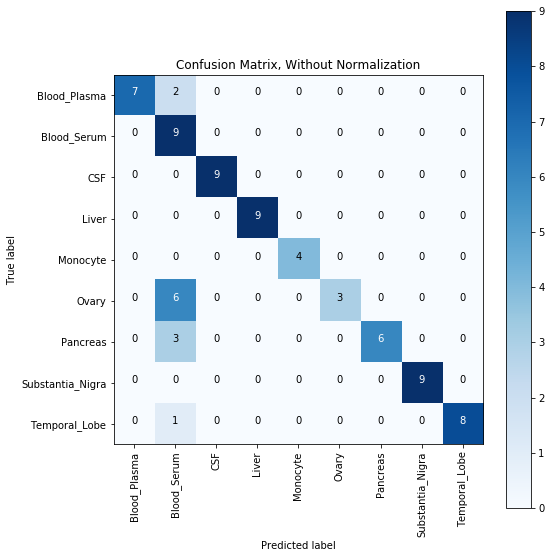

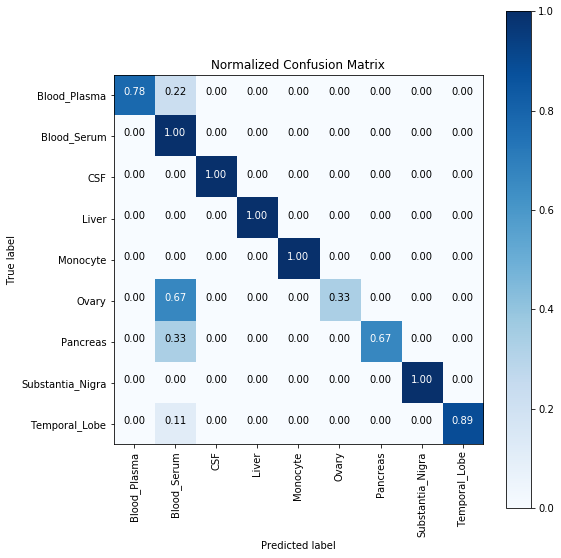

In [32]:
cu.show_confusion_matrices(test_labels, mnb_grid_pred, tissues)